# Introduction to NLP functions in TensorFlow

In [8]:
# Check for GPU

In [9]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [10]:
# Get helper Functions
!wget https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py

--2023-12-04 14:02:46--  https://raw.githubusercontent.com/joe-seth/TensorFlow-Food-prediction-Computer-Vision-Project/main/extras/script_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10267 (10K) [text/plain]
Saving to: ‘script_functions.py.1’

script_functions.py 100%[===================>]  10.03K  --.-KB/s    in 0s      

2023-12-04 14:02:46 (67.5 MB/s) - ‘script_functions.py.1’ saved [10267/10267]



In [11]:
# Import series of helper functions from  the file
from script_functions import unzip_data, create_tensorboard_callback, plot_loss_curve, compare_historys

## Get the text dataset
The data that I'm going to be using is Kaggle's introduction to NLP dataset (text samples of tweets, labelled as disaster or not disaster)

In [12]:
# Unzip the data
unzip_data('/content/nlp-getting-started.zip')

## Visualize the text data

In [13]:
# import libraries
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
train_df['text'][26]

'Was in NYC last week!'

In [15]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [16]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [17]:
# How many total samples
len(train_df), len(test_df)

(7613, 3263)

In [18]:
# Visualize some random training examples
import random
random_index = random.randint(0, len(train_df)-5) # Create random indexes not higher than the total number of samples
for row in train_df_shuffled[['text', 'target']][random_index:random_index+5].itertuples():
  _, text, target = row
  print(f"Target : {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n {text}\n")
  print("___\n")

Target : 0 (not real disaster)
Text:
 1 pair new 27w 4''  ROUND LED Work Driving FLOOD Light Off-road ATV UTV - Full read by eBay http://t.co/d3P88xdLEc http://t.co/j2DDvh7fY0

___

Target : 0 (not real disaster)
Text:
 I want to go back to Vegas for my 21 but I feel like that would be such a disaster lol so much money would need to be brought

___

Target : 0 (not real disaster)
Text:
 Mum's literally just picked up her new car today and flattened the battery already trying to sort out the Bluetooth ???? #Muppet

___

Target : 0 (not real disaster)
Text:
 DESCRIPTIONS OF 'WOUNDED CATS BEING 'EXCITING' http://t.co/BJycRGfH5y

___

Target : 0 (not real disaster)
Text:
 When love and hate collided part II
Lanjut dirumah...

#yagitudeh - Jake (at Rumah Cipinang) ÛÓ https://t.co/yiLt1Bb68k

___



In [19]:
# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled['target'].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [20]:
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [21]:
 # Check the first 10
 train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

In [22]:
# Convert text to numbers
import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default tokenization parameters
text_vectorizer = TextVectorization(max_tokens = None,
                                    standardize = 'lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode = "int",
                                    output_sequence_length = None,
                                    pad_to_max_tokens = False,
                                    vocabulary= None)


In [23]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [24]:
# Setup text Vectorization variables
max_vocab_length = 10000 # Max number of words to have in our vocabulary
max_length = 15 # Max length our sequence will be (eg. how many words will our )

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode='int',
                                    output_sequence_length=max_length)

In [25]:
# Fit the text vectorizer to the training set
text_vectorizer.adapt(train_sentences)

In [26]:
# Create sample sentence and tokenize it
sample_sentence = "There are floods in Kenya right now!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[  74,   22,  207,    4, 3707,  179,   48,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [27]:
# Choose a random sentences from the trainin dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 The summer program I worked for went the city pool we had to evacuate because one of my kids left a surprise. @jimmyfallon #WorstSummerJob

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[   2,  270, 1377,    8, 1733,   10,  492,    2,  182, 1616,   46,
          94,    5,  279,  152]])>

In [28]:
# Get the unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary() #get all the unique words in our training data
top_5_words = words_in_vocab[:5] # the most common words
bottom_5_words = words_in_vocab[-5:] # least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 common words : {top_5_words}")
print(f"Least common words : {bottom_5_words}")

Number of words in vocab: 10000
5 common words : ['', '[UNK]', 'the', 'a', 'in']
Least common words : ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [29]:
train_sentences

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

## Creating an Embedding using an Embedding layer
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding

In [30]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim = max_vocab_length, #set input shape
                             output_dim = 128,
                             embeddings_initializer='uniform',
                             input_length=max_length # how long is each input
)

embedding



In [31]:
# Get a random sentences from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
\n\nEmbedded version:")

# Embed the random sentence(turn it into dense vectors  of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 #Glaucoma occurs when fluid builds up pressure inside #eye to a level that may damage optic nerve #eyefacts

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.00255347,  0.01858212, -0.00954095, ..., -0.00392165,
         -0.02291691,  0.02012941],
        [-0.01035253, -0.00515496, -0.0476924 , ...,  0.03223013,
          0.02456624,  0.00236684],
        [ 0.00310428,  0.04322651, -0.01527832, ...,  0.04372492,
          0.01661911, -0.03316095],
        ...,
        [ 0.03656337,  0.00557405,  0.00506588, ..., -0.01410593,
         -0.01520896, -0.04167746],
        [-0.00081252,  0.02043902,  0.04731423, ..., -0.00806643,
         -0.01300985,  0.03600163],
        [ 0.03503796,  0.01013888, -0.02869214, ..., -0.04591892,
         -0.04064869,  0.02730886]]], dtype=float32)>

In [32]:
# Check out a single token's embedding
sample_embed[0][0], sample_embed[0][0].shape, random_sentence[0]

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([-0.00255347,  0.01858212, -0.00954095,  0.02391354,  0.01273564,
         0.03193379,  0.0171666 , -0.02495303,  0.04010009,  0.02143956,
         0.0362751 , -0.03701526,  0.00642604,  0.03476157,  0.03150168,
        -0.0212402 , -0.02722936,  0.02403719,  0.03738445,  0.03425392,
        -0.00935503,  0.02055172, -0.03906647, -0.00248926, -0.04483486,
         0.03541091, -0.03089681, -0.04492605, -0.03669365, -0.03317834,
        -0.0183143 ,  0.03539776,  0.02024159,  0.02240795, -0.01291402,
        -0.025535  , -0.0365127 ,  0.01059029,  0.01696289, -0.0489781 ,
        -0.00509053, -0.04048002,  0.0192742 , -0.00026799,  0.04965979,
         0.02087817,  0.01150254,  0.01358319,  0.03880701, -0.02974845,
        -0.04128102, -0.03919905, -0.04222958,  0.04281138, -0.0229084 ,
         0.04683304, -0.03277864,  0.02958876, -0.02696267,  0.02233782,
        -0.03377602,  0.04343924,  0.0163582 , -0.02421623, -0.02870855,
  

## Modelling text data
Turn the text sequence into numbers and start building a series of modeling experiments.
* Model 0: Naive Bayes (baseline), this is from SKLearn ML map
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM Model (RNN)
* Model 3: GRU Model (RNN)
* Model 4: Biderectional-LSTM model(RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6 TensorFlow Hbb pretrained Feature Extractor (Using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training


### Standard steps
* Create a model
* Build a model
* Fit a model
* Evaluate a model

### Model 0: Getting a baseline (baseline for future experiments)
Use Sklearns Mulitinomial Naive bayes using the TensorFlow IDF formula to convert words into numbers.

In [33]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()), # model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [34]:
# Evaluate the model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of : {baseline_score * 100:.2f}%")

Our baseline model achieves an accuracy of : 79.27%


In [35]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [36]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Create  a function for evaluating the metrics

In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, precision_recall_fscore_support

def evaluate_model(model_name, y_true, y_pred):
    """
    Calculates model accuracy, precision, recall and f1 score of a binary classification model.

    Args:
    -----
    y_true = true labels in the form of a 1D array
    y_pred = predicted labels in the form of a 1D array

    Returns a dictionary of accuracy, precision, recall, f1-score.
    """
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
    model_results = {"accuracy": model_accuracy,
                    "precision": model_precision,
                    "recall": model_recall,
                    "f1": model_f1}
    return model_results

In [38]:
baseline_results = evaluate_model(model_0, val_labels, baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model_1: Build a simple dense model

In [39]:
# Create  a tensorboard callback(need to create a new one for each model)
from script_functions import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [40]:
# Build model with the Functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # create an embedding of the numerized numbers
x = layers.GlobalAveragePooling1D()(x) # lower the dimensionality of the embedding (try running the model without this layer and see what happens)
outputs = layers.Dense(1, activation="sigmoid")(x) # create the output layer, want binary outputs so use sigmoid activation
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

In [41]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [42]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [43]:
# Fit the model

model_1_history = model_1.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20231204-140249
Epoch 1/5
215/215 [==============================] - 6s 23ms/step - loss: 0.6108 - accuracy: 0.6935 - val_loss: 0.5374 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 6s 26ms/step - loss: 0.4411 - accuracy: 0.8202 - val_loss: 0.4715 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.3456 - accuracy: 0.8613 - val_loss: 0.4580 - val_accuracy: 0.7874
Epoch 4/5
215/215 [==============================] - 4s 21ms/step - loss: 0.2836 - accuracy: 0.8899 - val_loss: 0.4680 - val_accuracy: 0.7861
Epoch 5/5
215/215 [==============================] - 6s 27ms/step - loss: 0.2369 - accuracy: 0.9114 - val_loss: 0.4827 - val_accuracy: 0.7861


In [44]:
# Check the results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 2ms/step - loss: 0.4827 - accuracy: 0.7861


[0.4827459156513214, 0.7860892415046692]

In [45]:
# Make predictions
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[0]

24/24 [==============================] - 0s 3ms/step


array([0.3561043], dtype=float32)

In [46]:
# Look at the first 10 predictions
model_1_pred_probs[:10]

array([[0.3561043 ],
       [0.828053  ],
       [0.9981657 ],
       [0.08241121],
       [0.13129412],
       [0.9275942 ],
       [0.92581564],
       [0.9936331 ],
       [0.9610841 ],
       [0.20979662]], dtype=float32)

In [47]:
# Converte model prediction probabilities to label format
model_1_pred_probs = tf.squeeze(tf.round(model_1_pred_probs))
model_1_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [48]:
# Calcutate our model_1 predictions
model_1_results = evaluate_model(model_name = model_1,
                                 y_true=val_labels,
                                 y_pred=model_1_pred_probs)
model_1_results

{'accuracy': 78.60892388451444,
 'precision': 0.7911704681403405,
 'recall': 0.7860892388451444,
 'f1': 0.7830068921982195}

## Visualize learned embeddings

In [49]:
# Get the vocabulary from the text vectoriizer layer
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [50]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1280129 (4.88 MB)
Trainable params: 128

In [52]:
# Get the weight matix of embedding layer
# These are the numerical representation of each token in our training  data which have been learned for 5 epochs
embed_weights  = model_1.get_layer("embedding").get_weights()
embed_weights

[array([[ 0.03106946,  0.04702741, -0.04981085, ...,  0.02910556,
         -0.01130534,  0.00447916],
        [ 0.00547564,  0.02658836, -0.01659133, ...,  0.00299507,
         -0.01684527,  0.02800069],
        [ 0.04662355,  0.0362196 , -0.00055798, ..., -0.00474281,
          0.06054917,  0.05754166],
        ...,
        [-0.01691758, -0.00870576,  0.03500812, ...,  0.01268947,
          0.00046095,  0.02721748],
        [ 0.05647383,  0.04431076, -0.04081597, ..., -0.00152084,
          0.01714515,  0.05426169],
        [ 0.074767  ,  0.04470479, -0.0438632 , ...,  0.08464558,
          0.11211406,  0.06186374]], dtype=float32)]

> Visualize using projector: https://www.tensorflow.org/tensorboard/tensorboard_projector_plugin

In [53]:
# Visualize using the projector
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [54]:
len(embed_weights)

1

# Recurrent Neural Network
RNN's are useful for sequence data.
The premise of a current neural network is to  use the representation of a previous input to aid the representation of a later input

### Model 2: LSTM
Long Short Term Memory

In [55]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype='string')
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.LSTM(64, return_sequences=True)(x) # When stacking l
print(x.shape)
x = layers.LSTM(64)(x)
print(x.shape)
x = layers.Reshape((-1, 1))(x)
x = layers.LSTM(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs, outputs, name='model_2_LSTM')


(None, 15, 128)
(None, 15, 64)
(None, 64)


In [56]:
# Compile the model
model_2.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [57]:
# Fit the model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: model_logs/model_2_LSTM/20231204-140529
Epoch 1/5
215/215 [==============================] - 27s 91ms/step - loss: 0.3389 - accuracy: 0.8670 - val_loss: 0.6395 - val_accuracy: 0.7835
Epoch 2/5
215/215 [==============================] - 19s 87ms/step - loss: 0.1757 - accuracy: 0.9385 - val_loss: 1.0572 - val_accuracy: 0.7822
Epoch 3/5
215/215 [==============================] - 19s 90ms/step - loss: 0.1394 - accuracy: 0.9498 - val_loss: 0.8051 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 19s 88ms/step - loss: 0.1154 - accuracy: 0.9574 - val_loss: 0.8458 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 19s 86ms/step - loss: 0.1010 - accuracy: 0.9616 - val_loss: 1.1296 - val_accuracy: 0.7756


In [58]:
# Make prediction
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 2s 18ms/step


array([[0.20213617],
       [0.8014382 ],
       [1.        ],
       [0.23833823],
       [0.043836  ],
       [1.        ],
       [0.9863707 ],
       [1.        ],
       [1.        ],
       [0.43612027]], dtype=float32)

In [59]:
# Convert model 2  pred probs to labels
model_2_pred_probs = tf.squeeze(tf.round(model_2_pred_probs))
model_2_pred_probs[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [60]:
# Calculate model 2  results
model_2_results = evaluate_model(model_2,
                                 y_true=val_labels,
                                 y_pred = model_2_pred_probs)
model_2_results

{'accuracy': 77.55905511811024,
 'precision': 0.7761484506083779,
 'recall': 0.7755905511811023,
 'f1': 0.7741998997022081}

## Model 3: GRU

In [61]:
# Build and RNN using GRU cell

# Set random seed and create embedding layer (new embedding layer for each model)
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build an RNN using the GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
# x = layers.GRU(64, return_sequences=True) # stacking recurrent cells requires return_sequences=True
x = layers.GRU(64)(x)
# x = layers.Dense(64, activation="relu")(x) # optional dense layer after GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [62]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1317313 (5.03 MB)
Trainable params: 1317313 (5.03 MB)
Non-trainable params: 0 (0.00 Byte)
_________________

In [63]:
# Compile the model
model_3.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [64]:
# Fit the model
model_3_history = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data= (val_sentences, val_labels),
                              callbacks =[create_tensorboard_callback(SAVE_DIR,
                                                                       "model_3_GRU")])

Saving TensorBoard log files to: model_logs/model_3_GRU/20231204-140800
Epoch 1/5
215/215 [==============================] - 13s 46ms/step - loss: 0.5227 - accuracy: 0.7324 - val_loss: 0.4540 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 8s 37ms/step - loss: 0.3194 - accuracy: 0.8711 - val_loss: 0.4923 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 16s 75ms/step - loss: 0.2196 - accuracy: 0.9183 - val_loss: 0.5584 - val_accuracy: 0.7756
Epoch 4/5
215/215 [==============================] - 12s 56ms/step - loss: 0.1602 - accuracy: 0.9442 - val_loss: 0.6189 - val_accuracy: 0.7795
Epoch 5/5
215/215 [==============================] - 8s 37ms/step - loss: 0.1226 - accuracy: 0.9577 - val_loss: 0.5998 - val_accuracy: 0.7743


In [65]:
# Make Predictions
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 1s 8ms/step


array([[0.33327547],
       [0.8713474 ],
       [0.99721646],
       [0.13690045],
       [0.01896398],
       [0.98870873],
       [0.7082449 ],
       [0.9971721 ],
       [0.99734825],
       [0.53907424]], dtype=float32)

In [66]:
# Convert Model_3 pred probs to lables
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds

<tf.Tensor: shape=(762,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 0.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       0., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0.,
       1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0

In [67]:
# Calculate model 3 resuults
model_3_results = evaluate_model(model_3, val_labels, model_3_preds)
model_3_results

{'accuracy': 77.42782152230971,
 'precision': 0.7741317342942483,
 'recall': 0.7742782152230971,
 'f1': 0.773426649133647}

In [68]:
# Build model Using Bi directional Neural network
from tensorflow.keras import layers
inputs = layers.Input(shape = (1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
#x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(1, activation='sigmoid')(x)
model_4  = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")


In [69]:
# Get the summary
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1378945 (5.26 MB)
Trainable par

In [70]:
# Compile the model
model_4.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [71]:
# Fit the model
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_4_bidirectional")])

Saving TensorBoard log files to: model_logs/model_4_bidirectional/20231204-140859
Epoch 1/5
215/215 [==============================] - 18s 64ms/step - loss: 0.1303 - accuracy: 0.9578 - val_loss: 0.7327 - val_accuracy: 0.7782
Epoch 2/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0825 - accuracy: 0.9685 - val_loss: 0.9041 - val_accuracy: 0.7769
Epoch 3/5
215/215 [==============================] - 11s 51ms/step - loss: 0.0645 - accuracy: 0.9714 - val_loss: 1.2009 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 13s 60ms/step - loss: 0.0568 - accuracy: 0.9750 - val_loss: 1.0588 - val_accuracy: 0.7703
Epoch 5/5
215/215 [==============================] - 12s 54ms/step - loss: 0.0498 - accuracy: 0.9758 - val_loss: 1.3132 - val_accuracy: 0.7677


In [72]:
# Make predictions
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 10ms/step


array([[2.7500045e-01],
       [6.2012398e-01],
       [9.9995774e-01],
       [7.4078552e-02],
       [2.3409531e-05],
       [9.9985391e-01],
       [9.9661630e-01],
       [9.9998260e-01],
       [9.9996102e-01],
       [6.8879890e-01]], dtype=float32)

In [73]:
# Covert pred probs to pred labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [74]:
# Evaluate the model
model_4_results = evaluate_model(model_4, val_labels, model_4_preds)
model_4_results

{'accuracy': 76.77165354330708,
 'precision': 0.7673725996279359,
 'recall': 0.7677165354330708,
 'f1': 0.7670623230765297}

# Convolutional Neural Networks for Text

In [75]:
# Test our embedding layer, Conv1D layer and max pooling
from tensorflow.keras  import layers
embedding_test = embedding(text_vectorizer(["this is a test sentence"])) # turn target into
conv_1d = layers.Conv1D(filters=32, # you can also change to 64
                        kernel_size=5, #ngram of 5 - meaning it looks at 5 words at a time
                        activation='relu',
                        padding="valid") #default = 'valid', the output is smaller than
conv_1d_output = conv_1d(embedding_test) # pass test embedding through conv1d layer
max_pool = layers.GlobalAveragePooling1D()
max_pool_output = max_pool(conv_1d_output) # equivalent to 'get the most important features

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [76]:
embedding_test

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[-0.01871293,  0.01146785, -0.02306901, ..., -0.02987252,
          0.03644706, -0.01660125],
        [ 0.04414966, -0.00776332, -0.00173697, ...,  0.08509   ,
         -0.02111465,  0.07455273],
        [ 0.01430357,  0.0202953 ,  0.00819521, ..., -0.0300554 ,
          0.01137167,  0.02711669],
        ...,
        [ 0.02398507,  0.02075431, -0.02685622, ...,  0.01441395,
         -0.00440935, -0.00243256],
        [ 0.02398507,  0.02075431, -0.02685622, ...,  0.01441395,
         -0.00440935, -0.00243256],
        [ 0.02398507,  0.02075431, -0.02685622, ...,  0.01441395,
         -0.00440935, -0.00243256]]], dtype=float32)>

In [77]:
conv_1d_output

<tf.Tensor: shape=(1, 11, 32), dtype=float32, numpy=
array([[[0.06853269, 0.        , 0.        , 0.05909761, 0.        ,
         0.        , 0.02009983, 0.01051244, 0.        , 0.01051882,
         0.03414802, 0.03580263, 0.        , 0.03874665, 0.08606036,
         0.0314342 , 0.03806323, 0.06775194, 0.03410441, 0.        ,
         0.        , 0.        , 0.02605595, 0.01046083, 0.06494435,
         0.        , 0.02930277, 0.01607565, 0.        , 0.        ,
         0.07168997, 0.03791971],
        [0.02631372, 0.        , 0.        , 0.08017004, 0.        ,
         0.01526533, 0.02309411, 0.02928027, 0.03655265, 0.00461607,
         0.06989193, 0.048516  , 0.        , 0.03126061, 0.        ,
         0.        , 0.00995292, 0.02824759, 0.        , 0.00609883,
         0.00408412, 0.07511196, 0.05066711, 0.        , 0.01022671,
         0.        , 0.0123646 , 0.00740598, 0.        , 0.        ,
         0.03885641, 0.04372391],
        [0.05244245, 0.        , 0.00248021, 0.0407

In [78]:
max_pool_output

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[0.01572362, 0.        , 0.01060375, 0.02480976, 0.        ,
        0.00186005, 0.05856365, 0.00361752, 0.01433167, 0.0013759 ,
        0.00945818, 0.02871691, 0.        , 0.00793365, 0.01624118,
        0.00327979, 0.00510352, 0.01226218, 0.02382658, 0.00106268,
        0.02277351, 0.0155841 , 0.02081915, 0.01859313, 0.00683373,
        0.        , 0.01967995, 0.01312832, 0.00994293, 0.        ,
        0.04407997, 0.00948334]], dtype=float32)>

In [79]:
# Create 1-Dimensional Convolutional layer to model sequnces
from tensorflow.keras import layers
inputs = layers.Input(shape =(1,), dtype = tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=64,
                  kernel_size=5,
                  strides=1,
                  activation='relu',
                  padding='valid')(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation = 'relu')(x)
outputs = layers.Dense(1, activation ="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="modle_5_Conv1D")

# Compile Conve 1D
model_5.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

# Get the model summary
model_5.summary()

Model: "modle_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (Text  (None, 15)                0         
 Vectorization)                                                  
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_4 (Dense)             (None, 1)              

In [80]:
# Fit the modle
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "modle_5_Conv1D")])

Saving TensorBoard log files to: model_logs/modle_5_Conv1D/20231204-141027
Epoch 1/5
215/215 [==============================] - 8s 32ms/step - loss: 0.1320 - accuracy: 0.9581 - val_loss: 0.8166 - val_accuracy: 0.7861
Epoch 2/5
215/215 [==============================] - 7s 33ms/step - loss: 0.0825 - accuracy: 0.9688 - val_loss: 0.9890 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 7s 32ms/step - loss: 0.0676 - accuracy: 0.9740 - val_loss: 1.0365 - val_accuracy: 0.7717
Epoch 4/5
215/215 [==============================] - 7s 34ms/step - loss: 0.0596 - accuracy: 0.9768 - val_loss: 1.1194 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 6s 29ms/step - loss: 0.0534 - accuracy: 0.9780 - val_loss: 1.1920 - val_accuracy: 0.7730


In [81]:
# Make prediction
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[8.2441039e-02],
       [5.8348721e-01],
       [9.9994946e-01],
       [6.6452265e-02],
       [1.9114196e-07],
       [9.9633718e-01],
       [9.8871535e-01],
       [9.9998450e-01],
       [9.9999917e-01],
       [8.0259389e-01]], dtype=float32)

In [82]:
# Convert pred_probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [83]:
# EValaute the model
model_5_results  = evaluate_model(model_5, val_labels, model_5_preds)
model_5_results

{'accuracy': 77.29658792650919,
 'precision': 0.7742755789705,
 'recall': 0.7729658792650919,
 'f1': 0.7710949612836401}

# Model 6 TensorFlow Hub Pretraind Sentence Encoder

> Try using Transfer Learning for NLP

In [84]:
import tensorflow_hub as hub
import tensorflow as tf

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embeddings = embed([
    sample_sentence,
    "I am a sentence for which I would like to get its embedding"])

print(embeddings[0][:50])


tf.Tensor(
[-0.04233878  0.04008291 -0.02360674 -0.00899752  0.01872467  0.08632939
 -0.02454613  0.02445058  0.03908568 -0.0396123  -0.00150612  0.03821141
  0.04628529  0.06803544  0.00024925 -0.07256007 -0.03863726 -0.03943938
 -0.04795679 -0.05120835 -0.00287391  0.05764361  0.03454439  0.06376503
  0.01039098 -0.06708851 -0.04333736 -0.04615705 -0.0147972  -0.0060136
 -0.04105301  0.03506071 -0.00807821 -0.03389785  0.05373822 -0.04070066
 -0.05876168 -0.0016974   0.03013574 -0.05594995  0.05496309 -0.05171396
 -0.00530536  0.0664724  -0.09104508  0.02660757  0.00339832  0.01714559
 -0.07698468  0.0027674 ], shape=(50,), dtype=float32)


In [85]:
embeddings.shape

TensorShape([2, 512])

In [86]:
# Create Keras layer using the USE pretrained layer form tensorflow hub
sentence_encoder_layerr = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                         input_shape=[],
                                         dtype= tf.string,
                                         trainable=False,
                                         name="USE"
                                         )

In [87]:
# Create model using the sequential API
model_6 = tf.keras.Sequential([
    sentence_encoder_layerr,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name = "model_6_USE")

In [88]:
# Compile the model
model_6.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [89]:
# Train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data = (val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "tf_hub_sentence_encoder")])


Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20231204-141141
Epoch 1/5
215/215 [==============================] - 9s 26ms/step - loss: 0.5089 - accuracy: 0.7819 - val_loss: 0.4464 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.4143 - accuracy: 0.8142 - val_loss: 0.4346 - val_accuracy: 0.8136
Epoch 3/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3990 - accuracy: 0.8219 - val_loss: 0.4299 - val_accuracy: 0.8136
Epoch 4/5
215/215 [==============================] - 5s 21ms/step - loss: 0.3910 - accuracy: 0.8282 - val_loss: 0.4261 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 4s 18ms/step - loss: 0.3845 - accuracy: 0.8301 - val_loss: 0.4277 - val_accuracy: 0.8163


In [90]:
# Make prediction with USE TF HUb Model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 1s 14ms/step


array([[0.15560204],
       [0.7480931 ],
       [0.990883  ],
       [0.20573777],
       [0.729087  ],
       [0.67816263],
       [0.9841023 ],
       [0.9804067 ],
       [0.93103427],
       [0.08906863]], dtype=float32)

In [91]:
# Covert pred probs to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [92]:
# Evaluate the pretrianed model
model_6_results = evaluate_model(model_6, val_labels, model_6_preds)
model_6_results

{'accuracy': 81.62729658792651,
 'precision': 0.8187546712946793,
 'recall': 0.8162729658792651,
 'f1': 0.8147089025083661}

In [93]:
len(train_sentences)

6851

# Model 7: TF Hub Pretrained USE  but with 10% of training data

> Indented block


Replicate model 6 except train it on 10% of the data

In [94]:
# Create subsets of 10% of the training data
train_10_percent = train_df_shuffled[['text', 'target']].sample(frac=0.1, random_state=42)
train_sentences_10_percent = train_10_percent['text'].to_list()
train_labels_10_percent = train_10_percent['target'].to_list()
len(train_sentences_10_percent), len(train_labels_10_percent)

(761, 761)

In [95]:
# Creare  10% dataset
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]
len(train_10_percent)

761

In [96]:
import numpy as np
import pandas as pd

In [97]:
# Check the number of each label
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

In [98]:
 # Check the number of targets in our subset of dat
train_10_percent['target'].value_counts()

0    413
1    348
Name: target, dtype: int64

In [99]:
train_df_shuffled['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

To recreate a model the same as the previous one, I will use tf.keras.clone.model() method
>https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [100]:
# Let's build a model the same as model_6
model_7 = tf.keras.models.clone_model(model_6)

# Compile the model
model_7.compile(loss='binary_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# Get the summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256830721 (979.73 MB)
Trainable params: 32897 (128.50 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [101]:
# Fit the model
model_7_history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs= 5,
                              validation_data=(val_sentences, val_labels),
                              callbacks = [create_tensorboard_callback(SAVE_DIR,
                                                                       "model_7_TF_Hub_sentence_encoder_10_percent")])

Saving TensorBoard log files to: model_logs/model_7_TF_Hub_sentence_encoder_10_percent/20231204-141215
Epoch 1/5
22/22 [==============================] - 5s 58ms/step - loss: 0.6714 - accuracy: 0.6920 - val_loss: 0.6526 - val_accuracy: 0.7362
Epoch 2/5
22/22 [==============================] - 1s 31ms/step - loss: 0.6055 - accuracy: 0.8175 - val_loss: 0.5969 - val_accuracy: 0.7690
Epoch 3/5
22/22 [==============================] - 1s 31ms/step - loss: 0.5316 - accuracy: 0.8175 - val_loss: 0.5406 - val_accuracy: 0.7822
Epoch 4/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4698 - accuracy: 0.8248 - val_loss: 0.5072 - val_accuracy: 0.7769
Epoch 5/5
22/22 [==============================] - 1s 30ms/step - loss: 0.4269 - accuracy: 0.8350 - val_loss: 0.4896 - val_accuracy: 0.7808


In [102]:
# Make predictions
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs[:10]

24/24 [==============================] - 1s 13ms/step


array([[0.21175227],
       [0.5910491 ],
       [0.91787374],
       [0.3697779 ],
       [0.5222159 ],
       [0.6925556 ],
       [0.8944465 ],
       [0.8191099 ],
       [0.8541804 ],
       [0.16671392]], dtype=float32)

In [103]:
# Convert pred probs to labels
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [104]:
# Evaluate the model
model_7_results = evaluate_model(model_7, val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7818764826324955,
 'recall': 0.7808398950131233,
 'f1': 0.7792643495521726}

Performs slightly worse than with the original full data

## Comparing the Perfomance of each models

In [105]:
# Evaluate the model
model_7_results = evaluate_model(model_7, val_labels, model_7_preds)
model_7_results

{'accuracy': 78.08398950131233,
 'precision': 0.7818764826324955,
 'recall': 0.7808398950131233,
 'f1': 0.7792643495521726}

In [106]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_lstm": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_sentence_encoder": model_6_results,
                                  "7_tf_hub_10_percent_data": model_7_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.608924,0.791170,0.786089,0.783007
2_lstm,77.559055,0.776148,0.775591,0.774200
3_gru,77.427822,0.774132,0.774278,0.773427
4_bidirectional,76.771654,0.767373,0.767717,0.767062
5_conv1d,77.296588,0.774276,0.772966,0.771095
6_tf_hub_sentence_encoder,81.627297,0.818755,0.816273,0.814709
7_tf_hub_10_percent_data,78.083990,0.781876,0.780840,0.779264


In [107]:
# Reduce the accuracy to the same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100

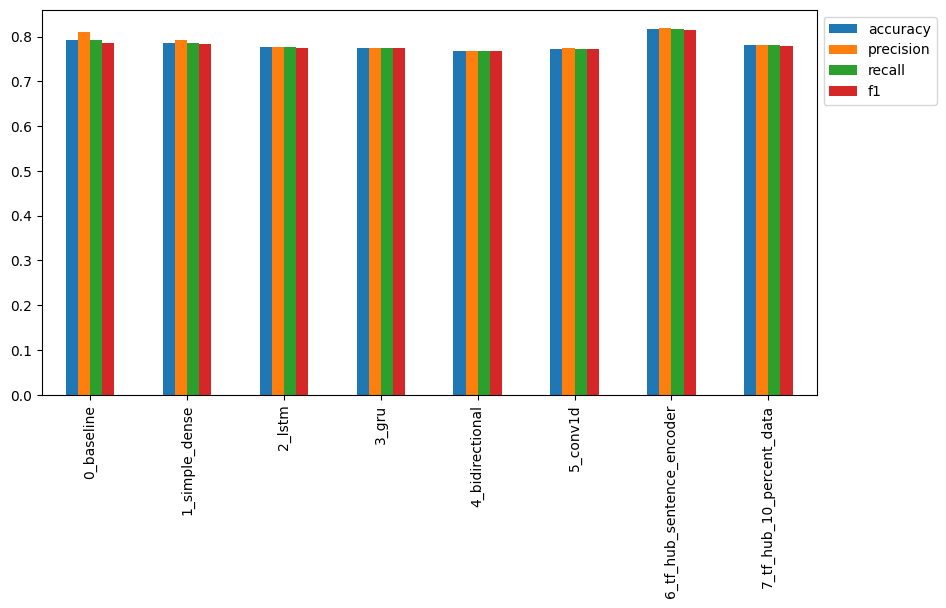

In [108]:
# Visuali the plots and compare the model's results
all_model_results.plot(kind='bar', figsize=(10,5)).legend(bbox_to_anchor=(1.0, 1.0));

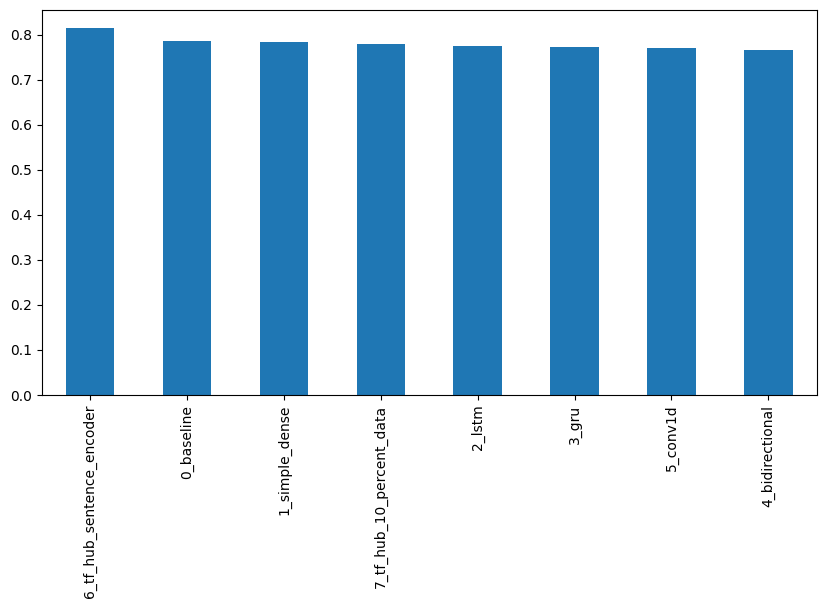

In [109]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind='bar', figsize=(10, 5));

In [ ]:
# View TensorBoard Logs of transfer learning and all other models
# Upload TensorBoard logs
!tensorboard dev upload  --logdir  ./content/model_logs \
--name "NLP Modelling Experiments for disaster tweets" \
--description "Comparing multiple different types of model architectures on the Kaggle tweets text classfication dataset" \
--one_shot # Exit the uploader once uploading is finished

## Saving and Loading a Trained Model
There are 2 main methods todel in TensorFlow:
1. The `HDF5`
2.  `SavedModel` format

In [111]:
# Save TF HUB HDF5 format
model_6.save("model_6.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [113]:
# Load model with custom Hub Layer (required HDF5 format)
import tensorflow_hub as hub
loaded_model_6 = tf.keras.models.load_model("model_6.h5", custom_objects={"KerasLayer": hub.KerasLayer})

In [114]:
# H{ow does the loaded model perform?
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 20ms/step - loss: 0.4277 - accuracy: 0.8163


[0.4276897609233856, 0.8162729740142822]

### Using the savedmodel format

In [115]:
# SavedModel format is actually the default
model_6.save("model_6_SavedModel_format")

In [119]:
# Loading the savedmodel format
loaded_model_6_savedmodel_format = tf.keras.models.load_model("model_6_SavedModel_format")

In [124]:
# EValuate the model
loaded_model_6_savedmodel_format.evaluate(val_sentences, val_labels)

24/24 [==============================] - 5s 23ms/step - loss: 0.4277 - accuracy: 0.8163


[0.4276897609233856, 0.8162729740142822]

## Visualize the most wrong examples

* If the best model still isn't perfect, what is it getting wrong. From these wrong examples, which one is it getting wrong?

In [127]:
# Download a pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-12-04 14:35:01--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.215.207, 173.194.216.207, 173.194.217.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.215.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip.1’

08_model_6_USE_feat 100%[===================>] 916.27M  34.7MB/s    in 26s     

2023-12-04 14:35:28 (34.9 MB/s) - ‘08_model_6_USE_feature_extractor.zip.1’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/var

In [129]:
# Import previously trained model form Google storage
model_6_pretrained = tf.keras.models.load_model("/content/08_model_6_USE_feature_extracto6")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 15ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723119258880615, 0.8162729740142822]

In [131]:
# Make predictions
model_6_pretrained_pred_probs = model_6_pretrained.predict(val_sentences)
model_6_pretrained_preds = tf.squeeze(tf.round(model_6_pretrained_pred_probs))
model_6_pretrained_preds[:10]

24/24 [==============================] - 0s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [134]:
# Create DataFrame with validation sentences, validation labels and best performing model predictions
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_probs": tf.squeeze(model_6_pretrained_pred_probs)})
val_df.head()

,text,target,pred,pred_probs
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [139]:
# Find the wrong the predictions and sort by prediction  probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_probs",ascending=False)
most_wrong[:10]

,text,target,pred,pred_probs
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835454
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [140]:
# Visualize the false positives
for row in most_wrong[:10].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target : {target}, Pred : {pred}, Prob : {pred_probs}")
  print(f"Text:\n {text} \n")
  print("---\n")


Target : 0, Pred : 1.0, Prob : 0.9101957082748413
Text:
 ? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying 

---

Target : 0, Pred : 1.0, Prob : 0.8769820332527161
Text:
 FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J 

---

Target : 0, Pred : 1.0, Prob : 0.8523001670837402
Text:
 @noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME. 

---

Target : 0, Pred : 1.0, Prob : 0.8354544043540955
Text:
 Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0 

---

Target : 0, Pred : 1.0, Prob : 0.8272131681442261
Text:
 @AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans. 

---

Target : 0, Pred : 1.0, Prob : 0.814815878868103
Text:
 @SonofLiberty357 all illuminated by the brightly burning buildings al

In [141]:
# Visualize false negatives
for row in most_wrong[-10:].itertuples():
  _, text, target, pred, pred_probs = row
  print(f"Target : {target}, Pred : {pred}, Prob : {pred_probs}")
  print(f"Text:\n {text} \n")
  print("---\n")

Target : 1, Pred : 0.0, Prob : 0.06730345636606216
Text:
 @DavidVonderhaar At least you were sincere ?? 

---

Target : 1, Pred : 0.0, Prob : 0.055075839161872864
Text:
 @willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu 

---

Target : 1, Pred : 0.0, Prob : 0.054603397846221924
Text:
 Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets 

---

Target : 1, Pred : 0.0, Prob : 0.05459701269865036
Text:
 going to redo my nails and watch behind the scenes of desolation of smaug ayyy 

---

Target : 1, Pred : 0.0, Prob : 0.04963730648159981
Text:
 You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you. 

---

Target : 1, Pred : 0.0, Prob : 0.04391849413514137
Text:
 @SoonerMagic_ I mean I'm a fan but I don't need a girl sounding off like a damn siren 

---

Target

In [142]:
test_df

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


## Making and Visualizing Predictions on the test dataset

In [146]:
test_sentences = test_df['text'].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6_pretrained.predict([test_sample]))
  pred = tf.round(pred_prob)
  print(f"Pred : {int(pred)}, Prob: {pred_prob}")
  print(f"Text: \n {test_sample} \n")
  print("----\n")

1/1 [==============================] - 0s 48ms/step
Pred : 0, Prob: 0.2843116521835327
Text: 
 @AlyssaSpencer28 remember when beau and i collided on the slip and slide and I died ?????? 

----

1/1 [==============================] - 0s 54ms/step
Pred : 0, Prob: 0.08871802687644958
Text: 
 @RVacchianoNYDN @NYDNSports glad to see a career rebirth for him.  Loved him in Carolina  injuries just caught up to him. 

----

1/1 [==============================] - 0s 50ms/step
Pred : 1, Prob: 0.9206011891365051
Text: 
 Despite past devastation fortunately #forgiveness mutual #respect and #peace emerged.  #Remember #Hiroshima and #Nagasaki 

----

1/1 [==============================] - 0s 51ms/step
Pred : 0, Prob: 0.11796365678310394
Text: 
 #People #Tilly the #Confused Cat Overcomes Horrible Attack to Win Hearts http://t.co/QtrsYxFzo3 

----

1/1 [==============================] - 0s 57ms/step
Pred : 1, Prob: 0.6369391083717346
Text: 
 #Gabon : Oil and Gas Exploration Takes Seismic Shift in Gabo

# Predicting Tweets on the Wild

# The Speed/Score Tradeoff

In [151]:
# Function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """

  start_time  = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter() # get finish time
  total_time = end_time-start_time # calculate how long prediction took to make
  time_per_pred = total_time/len(samples)

  return total_time, time_per_pred

In [153]:
# Calculate TF HUb sentences Encoder time per second
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model=model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 12ms/step


(0.3724667650003539, 0.0004888015288718556)

In [155]:
# Calculate baseline model time per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.03371474599953217, 4.42450734901997e-05)

In [156]:
model_6_pretrained_results = evaluate_model(model_6_pretrained, val_labels, model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

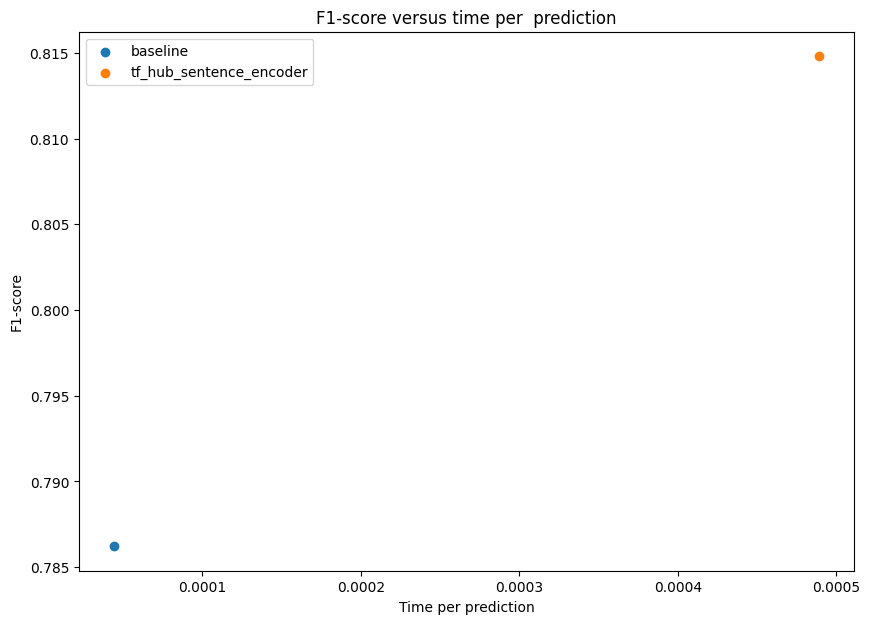

In [158]:
# Comparing the model's time per prediction versus the model's f1 score
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-score versus time per  prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

# Final findings.
The baseline model demonstrates exceptional speed and high performance, outpacing the TF Hub Sentence Encoder significantly in processing time. Despite the TF Hub model taking approximately ten times longer, it achieves a higher F1 score compared to the baseline.

When considering deployment, the decision lies between a faster-performing baseline model with a lower F1 score and the TF Hub Sentence Encoder, which exhibits a higher F1 score but operates substantially slower. The trade-off here involves selecting between speed and accuracy. The baseline's swiftness could be advantageous in certain real-time applications, while the TF Hub model's increased accuracy might be more critical in scenarios where precision is paramount, even with the trade-off in speed. The choice ultimately hinges on the specific requirements and priorities of the deployment scenario.